In [1]:
%pylab inline
from astropy.table import Table
from rnn import RNNClassifier
import tensorflow as tf
import matplotlib.pyplot as plt
import copy

Populating the interactive namespace from numpy and matplotlib


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [62]:
#Calculate S/N
        
from astropy.io import ascii

def get_individual_SNR(filename):
    rdr = ascii.get_reader(Reader=ascii.Basic)
    rdr.header.splitter.delimiter = ' '
    rdr.data.splitter.delimiter = ' '
    rdr.header.start_line = 12
    rdr.data.start_line = 13
    rdr.data.end_line = None
    t = rdr.read('DES_BLINDnoHOSTZ/' + filename)
    
    FLUXCALERR = t['FLUXCALERR']
    MJD = t['MJD']
    UMJD = MJD[FLUXCALERR>0]
    FLT = t['FLT']
    UFLT = FLT[FLUXCALERR>0]
    FLUXCAL = t['FLUXCAL']
    UFLUXCAL = FLUXCAL[FLUXCALERR>0]
    UFLUXCALERR = FLUXCALERR[FLUXCALERR>0]
    
    G_FLUX = UFLUXCAL[UFLT == 'g']
    G_Error = UFLUXCALERR[UFLT == 'g']
    
    R_FLUX = UFLUXCAL[UFLT == 'r']
    R_Error = UFLUXCALERR[UFLT == 'r']
    
    I_FLUX = UFLUXCAL[UFLT == 'i']
    I_Error = UFLUXCALERR[UFLT == 'i']
    
    Z_FLUX = UFLUXCAL[UFLT == 'z']
    Z_Error = UFLUXCALERR[UFLT == 'z']
    
    n = 0
    
    if np.size(G_FLUX) != 0:
        g_index = G_FLUX.argmax()
        G_SN = G_FLUX[g_index]/G_Error[g_index]
        n += 1
    else: G_SN = 0
        
    if np.size(R_FLUX) != 0:
        r_index = R_FLUX.argmax()
        R_SN = R_FLUX[r_index]/R_Error[r_index]
        n += 1
    else: R_SN = 0
    
    if np.size(I_FLUX) != 0:
        i_index = I_FLUX.argmax()
        I_SN = I_FLUX[i_index]/I_Error[i_index]
        n += 1
    else: I_SN = 0
    
    if np.size(Z_FLUX) != 0:
        z_index = Z_FLUX.argmax()
        Z_SN = Z_FLUX[z_index]/Z_Error[z_index]
        n += 1
    else: Z_SN = 0
    
    return np.sqrt(G_SN**2 + R_SN**2 + I_SN**2 + Z_SN**2)/np.sqrt(n) 

def get_SNR(group):
    name_list = group['FILENAME']
    total = len(name_list)
    index = 0
    SNR_list = []
    for index in range(total):
        SNR_list += [get_individual_SNR(name_list[index])]
    return SNR_list

In [63]:
# Loading dataset
#data_table = Table.read('normalized_sub_mean.fits')
#data_table = Table.read('normalized_good.fits')
data_table = Table.read('normalized_ahh.fits')

In [64]:
get_SNR(data_table[0:2])

[18.20744588004269, 27.560442612316297]

In [65]:
data_table['max_SNR'] = get_SNR(data_table)

In [66]:
data_table

FILENAME,SURVEY,SNID,SNTYPE,FILTERS,RA,DECL,FAKE,MWEBV,REDSHIFT_SPE,NOBS,NVAR,"DATA [50,9]",obs_length,num_data_points,max_SNR
bytes16,bytes7,bytes12,bytes5,bytes6,bytes21,bytes20,bytes35,bytes23,bytes25,bytes5,bytes3,float64,float64,int64,float64
DES_SN000018.DAT,DES,18,-9,griz,34.500000 deg,-5.500000 deg,3 (=> BLIND-TEST simulation),0.0227 MW E(B-V),-9.0000 +- 9.0000,118,5,0.0 .. 0.0,145.8949999999968,41,18.20744588004269
DES_SN000050.DAT,DES,50,-9,griz,36.750000 deg,-4.500000 deg,3 (=> BLIND-TEST simulation),0.0283 MW E(B-V),-9.0000 +- 9.0000,16,5,0.0 .. 0.0,30.93000000000029,9,27.560442612316297
DES_SN000051.DAT,DES,51,1,griz,52.500000 deg,-27.500000 deg,3 (=> BLIND-TEST simulation),0.0097 MW E(B-V),0.5177 +- 0.0050,121,5,0.0 .. 0.0,126.88300000000163,33,10.344807031052145
DES_SN000063.DAT,DES,63,-9,griz,34.500000 deg,-5.500000 deg,3 (=> BLIND-TEST simulation),0.0227 MW E(B-V),-9.0000 +- 9.0000,115,5,0.0 .. 0.0,127.9409999999989,37,7.616381701336491
DES_SN000064.DAT,DES,64,-9,griz,48.000000 deg,0.000000 deg,3 (=> BLIND-TEST simulation),0.0713 MW E(B-V),-9.0000 +- 9.0000,92,5,0.0 .. 0.0,117.89800000000105,31,1.803839760608783
DES_SN000096.DAT,DES,96,-9,griz,34.500000 deg,-5.500000 deg,3 (=> BLIND-TEST simulation),0.0227 MW E(B-V),-9.0000 +- 9.0000,104,5,0.0 .. 0.0,119.87900000000081,37,6.4214340047668905
DES_SN000122.DAT,DES,122,-9,griz,34.500000 deg,-5.500000 deg,3 (=> BLIND-TEST simulation),0.0227 MW E(B-V),-9.0000 +- 9.0000,11,5,0.0 .. 0.0,17.95300000000134,7,27.395543744676978
DES_SN000124.DAT,DES,124,-9,griz,48.000000 deg,0.000000 deg,3 (=> BLIND-TEST simulation),0.0713 MW E(B-V),-9.0000 +- 9.0000,95,5,0.0 .. 0.0,113.96500000000378,34,7.3828955570895065
DES_SN000156.DAT,DES,156,-9,griz,36.750000 deg,-4.500000 deg,3 (=> BLIND-TEST simulation),0.0283 MW E(B-V),-9.0000 +- 9.0000,87,5,0.0 .. 0.0,96.0309999999954,25,5.185880353848648


In [67]:
# Splitting training and testing data
np.random.seed(1234)
randomize_inds = range(len(data_table))
randomize_inds = permutation(randomize_inds)
randomized_inds_train = randomize_inds[0:15000]
randomized_inds_test  = randomize_inds[15000:]

In [68]:
data_table['label'] = 1.0*(data_table['SNTYPE'].astype('int') == 1)

In [69]:
# Define input function for training 
def input_fn_train():
    def mapping_function(x):
        def extract_batch(inds):
            inds = randomized_inds_train[inds]
            return data_table['label'][inds].astype('float32'), clip(data_table['num_data_points'][inds],0,49).astype('int32'),data_table['DATA'][inds].astype('float32') 
        a,b,c =tf.py_func( extract_batch, [x], [tf.float32, tf.int32, tf.float32])
        a.set_shape([None])
        b.set_shape([None])
        c.set_shape([None,50,9])
        return a,b,c

    dataset = tf.data.Dataset.range(len(randomized_inds_train))
    dataset = dataset.repeat().shuffle(10000).batch(512)
    dataset = dataset.map( mapping_function)
    iterator = dataset.make_one_shot_iterator()
    label, length, ts = iterator.get_next()
    return  {'length':length, 'ts':ts}, label

def input_fn_train_test():
    def mapping_function(x):
        def extract_batch(inds):
            inds = randomized_inds_train[inds]
            return data_table['label'][inds].astype('float32'), clip(data_table['num_data_points'][inds],0,49).astype('int32'),data_table['DATA'][inds].astype('float32')
        a,b,c =tf.py_func( extract_batch, [x], [tf.float32, tf.int32, tf.float32])
        a.set_shape([None])
        b.set_shape([None])
        c.set_shape([None,50,9])
        return a,b,c

    dataset = tf.data.Dataset.range(len(randomized_inds_train))
    dataset = dataset.batch(512)
    dataset = dataset.map( mapping_function)
    iterator = dataset.make_one_shot_iterator()
    label, length, ts = iterator.get_next()
    return  {'length':length, 'ts':ts}, label

def input_fn_test():
    def mapping_function(x):
        def extract_batch(inds):
            inds = randomized_inds_test[inds]
            return data_table['label'][inds].astype('float32'), clip(data_table['num_data_points'][inds],0,49).astype('int32'),data_table['DATA'][inds].astype('float32') 
        a,b,c =tf.py_func( extract_batch, [x], [tf.float32, tf.int32, tf.float32])
        a.set_shape([None])
        b.set_shape([None])
        c.set_shape([None,50,9])
        return a,b,c

    dataset = tf.data.Dataset.range(len(randomized_inds_test))
    dataset = dataset.batch(512)
    dataset = dataset.map( mapping_function)
    iterator = dataset.make_one_shot_iterator()
    label, length, ts = iterator.get_next()
    return  {'length':length, 'ts':ts}, label

In [70]:
#model = RNNClassifier(hidden_units=[128, 128], dropout=1, model_dir='tests/test_1')
#model = RNNClassifier(hidden_units=[128, 128], dropout=0.8, model_dir='tests/test_2')
#model = RNNClassifier(hidden_units=[128, 128], dropout=0.8, model_dir='tests/test_5')
#model = RNNClassifier(hidden_units=[128, 128], dropout=0.8, model_dir='tests/test_6')
#model = RNNClassifier(hidden_units=[128, 128], dropout=0.8, model_dir='tests/test_10')
#with good.fits
model = RNNClassifier(hidden_units=[128, 128], dropout=0.8, model_dir='tests/test_12')
#with ahh.fits

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': 'tests/test_12', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': None, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x11b0b44a8>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


In [71]:
#model.train(input_fn=input_fn_train, steps=10000)

In [72]:
# Apply model to test set
test_prob = [p['prob'] for p in model.predict(input_fn_test)]
table_test = data_table[randomized_inds_test]
table_test['p'] = test_prob

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from tests/test_12/model.ckpt-10000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


In [73]:
# Apply model to training set
train_prob = [p['prob'] for p in model.predict(input_fn_train_test)]
table_train = data_table[randomized_inds_train]
table_train['p'] = train_prob

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from tests/test_12/model.ckpt-10000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


In [74]:
#number of SNIa in the training set

SNIa_num = len(table_train[table_train['label']==1])
ratio = SNIa_num/len(table_train['label'])
print(SNIa_num,ratio)

669 0.0446


In [75]:
SNIa_num = len(table_train[table_train['SNTYPE'].astype('int')==33])
ratio = SNIa_num/len(table_train['label'])
print(SNIa_num,ratio)

48 0.0032


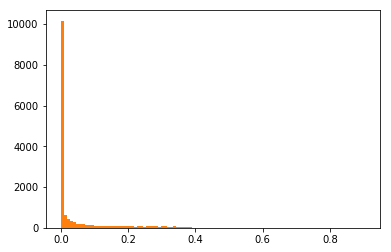

In [76]:
hist(test_prob, 100);
hist(train_prob,100);

In [80]:
# Compute ROC curves 
from sklearn.metrics import roc_curve

def plot_roc_curve(train,test):
    fpr1, tpr1, thr1 = roc_curve(train['label'], train['p'])
    fpr2, tpr2, thr2 = roc_curve(test['label'], test['p'])
    
    fig = plt.figure(figsize=(16, 3))
    
    subplot(131)
    plt.subplots_adjust(left=None, bottom=None, right=None, top=None,
                wspace=None, hspace=0.5)
    plot(fpr1, tpr1,label='train')
    plot(fpr2, tpr2,label='test')
    title("roc curve fp_tp")
    xlabel('false positive rate')
    ylabel('true positive rate')
    grid('on')
    #xscale('log')
    legend()
    xlim(0,1)
    ylim(0,1)
    
    subplot(132)
    plt.subplots_adjust(left=None, bottom=None, right=None, top=None,
                wspace=None, hspace=0.5)
    plot(thr1, tpr1,label='training set')
    plot(thr2, tpr2,label='testing set')
    title("roc curve thr_tp")
    xlabel('threshold')
    ylabel('true positive rate')
    grid('on')
    #xscale('log')
    legend()
    xlim(0,1)
    ylim(0,1)
    
    subplot(133)
    plt.subplots_adjust(left=None, bottom=None, right=None, top=None,
                wspace=None, hspace=0.5)
    plot(thr1, fpr1,label='training set')
    plot(thr2, fpr2,label='testing set')
    title("roc curve thr_fp")
    xlabel('threshold')
    ylabel('false positive rate')
    grid('on')
    #xscale('log')
    legend()
    xlim(0,1)
    ylim(0,1)

In [81]:
from sklearn.metrics import roc_auc_score

In [82]:
roc_auc_score(table_train['label'], table_train['p'])

0.9354093413267087

In [83]:
roc_auc_score(table_test['label'], table_test['p'])

0.9238538750166657

In [84]:
# Compute Confusion Matrix
from sklearn.metrics import confusion_matrix

threshold=0.083

actual = table_test['label']
predict = table_test['p'] > threshold

confusion_matrix(actual, predict)

array([[2759,  423],
       [  25,  140]])

In [85]:
FP = (table_test['p'] > threshold) * (table_test['label'] == 0)
TP = (table_test['p'] > threshold) * (table_test['label'] == 1)
FN = (table_test['p'] < threshold) * (table_test['label'] == 1)
TN = (table_test['p'] < threshold) * (table_test['label'] == 0)

P = (table_test['label'] == 1)
N = (table_test['label'] == 0)

FP_table = table_test[FP]
FN_table = table_test[FN]
TP_table = table_test[TP]
TN_table = table_test[TN]
P_table = table_test[P]
N_table = table_test[N]

print("fp: " + str(len(FP_table)))
print("fn: " + str(len(FN_table)))
print("tp: " + str(len(TP_table)))
print("tn: " + str(len(TN_table)))
print("p: " + str(len(P_table)))
print("n: " + str(len(N_table)))

fp: 423
fn: 25
tp: 140
tn: 2759
p: 165
n: 3182


In [86]:
# Compute Confusion Matrix for specific types

FP_orig_types = (FP_table['SNTYPE'].astype('int')).flatten()
FN_orig_types = (FN_table['SNTYPE'].astype('int')).flatten()
TN_orig_types = (TN_table['SNTYPE'].astype('int')).flatten()

FP_distr = []
for a in np.unique(FP_orig_types):
    FP_distr += [(str(a),len(FP_table[FP_orig_types == a]))]
    
TN_distr = []
for a in np.unique(TN_orig_types):
    TN_distr += [(str(a),len(TN_table[TN_orig_types == a]))]

In [87]:
(FP_distr, TN_distr)

([('-9', 400), ('3', 3), ('22', 1), ('23', 2), ('32', 9), ('33', 8)],
 [('-9', 2696), ('21', 10), ('22', 38), ('32', 9), ('33', 6)])

In [88]:
FP_nine = FP_table[FP_orig_types == -9]
FP_Ibc = FP_table[FP_orig_types == 3]
FP_IIn = FP_table[FP_orig_types == 21]
FP_IIP = FP_table[FP_orig_types == 22]
FP_IIL = FP_table[FP_orig_types == 23]
FP_Ib = FP_table[FP_orig_types == 32]
FP_Ic = FP_table[FP_orig_types == 33]

In [89]:
FN_nine = FN_table[FN_orig_types == -9]
FN_Ibc = FN_table[FN_orig_types == 3]
FN_IIn = FN_table[FN_orig_types == 21]
FN_IIP = FN_table[FN_orig_types == 22]
FN_IIL = FN_table[FN_orig_types == 23]
FN_Ib = FN_table[FN_orig_types == 32]
FN_Ic = FN_table[FN_orig_types == 33]

In [90]:
TN_nine = TN_table[TN_orig_types == -9]
TN_Ibc = TN_table[TN_orig_types == 3]
TN_IIn = TN_table[TN_orig_types == 21]
TN_IIP = TN_table[TN_orig_types == 22]
TN_IIL = TN_table[TN_orig_types == 23]
TN_Ib = TN_table[TN_orig_types == 32]
TN_Ic = TN_table[TN_orig_types == 33]

In [91]:
C_M = np.array([[len(TP_table), len(FP_nine), len(FP_IIn), len(FP_IIP), 
                 len(FP_IIL), len(FP_Ibc), len(FP_Ib), len(FP_Ic)],
                [len(FN_table), len(TN_nine), len(TN_IIn), len(TN_IIP),
                 len(TN_IIL), len(TN_Ibc), len(TN_Ib), len(TN_Ic)]])

In [92]:
C_M

array([[ 140,  400,    0,    1,    2,    3,    9,    8],
       [  25, 2696,   10,   38,    0,    0,    9,    6]])

In [93]:
# Normalize Confusion Matrix

C_M = C_M.astype('float64')
CM_copy = copy.deepcopy(C_M)
SUM = CM_copy.sum(axis=0)
SUM = SUM.astype('float64')
for i in range(len(SUM)):
    if SUM[i]>0:
        print(SUM[i])
        C_M[0,i] /= SUM[i]
        C_M[1,i] /= SUM[i]

165.0
3096.0
10.0
39.0
2.0
3.0
18.0
14.0


Normalized confusion matrix
[[0.84848485 0.12919897 0.         0.02564103 1.         1.
  0.5        0.57142857]
 [0.15151515 0.87080103 1.         0.97435897 0.         0.
  0.5        0.42857143]]


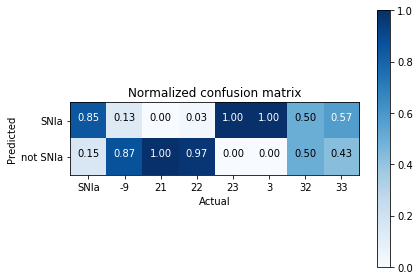

In [94]:
# Plot Confusion Matrix

import itertools
import numpy as np
import matplotlib.pyplot as plt

print("Normalized confusion matrix")
print(C_M)

np.set_printoptions(precision=2)
plt.figure()

plt.imshow(C_M, interpolation='nearest', cmap=plt.cm.Blues)
plt.title("Normalized confusion matrix")
plt.colorbar()

x_classes = np.array(['SNIa',"-9","21","22","23","3","32","33"])
y_classes = np.array(["SNIa", "not SNIa"])
x_marks = np.arange(len(x_classes))
y_marks = np.arange(len(y_classes))
plt.xticks(x_marks, x_classes)
plt.yticks(y_marks, y_classes)

fmt = '.2f'
thresh = C_M.max() / 2.
for i, j in itertools.product(range(C_M.shape[0]), range(C_M.shape[1])):
    plt.text(j, i, format(C_M[i, j], fmt), horizontalalignment="center",
                 color="white" if C_M[i, j] > thresh else "black")

plt.tight_layout()
plt.ylabel('Predicted')
plt.xlabel('Actual')

plt.show()


In [95]:
# Compute other metrics

Accuracy = (len(TP_table) + len(TN_table))/(len(table_test))
Purity = len(TP_table)/(len(TP_table) + len(FP_table))
Completeness = len(TP_table)/(len(TP_table) + len(FN_table))
FOM = Completeness * (len(TP_table)/(len(TP_table) + 3*len(FP_table)))

In [96]:
(Accuracy, Purity, Completeness, FOM)

(0.8661487899611593,
 0.24866785079928952,
 0.8484848484848485,
 0.08430651439877843)

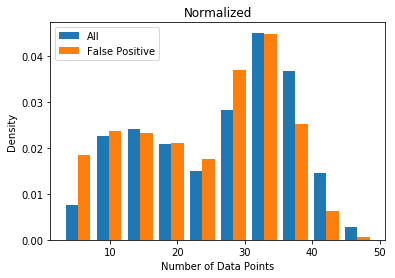

In [97]:
datapointshist = [table_test['num_data_points'],FP_table['num_data_points']]
hist(datapointshist, 10, density = True, histtype='bar', label = ["All","False Positive"])
xlabel('Number of Data Points')
ylabel('Density')
title('Normalized')
legend(prop={'size': 10})

In [98]:
# Make plots for missclassified types

def make_plots(dataset):
    
    output = dataset # Define which missclassified type to plot

    plot_ind = 0
    plot_tot = min(len(output),30) #for type -9 use a smaller number because there are too many

    while plot_ind < plot_tot: 
        plot_num = 321
        fig = plt.figure(figsize=(15, 14))
        for x in range(6):
            plt.rcParams.update({'font.size': 7.5})
            plt.subplot(plot_num)
            plt.subplots_adjust(left=None, bottom=None, right=None, top=None,
                wspace=None, hspace=0.5)
        
            num_points = output[plot_ind]['num_data_points']
            MJD = output['DATA'][plot_ind,:num_points,0]
            g_FLUXCAL = output['DATA'][plot_ind,:num_points,1]
            r_FLUXCAL = output['DATA'][plot_ind,:num_points,2]
            i_FLUXCAL = output['DATA'][plot_ind,:num_points,3]
            z_FLUXCAL = output['DATA'][plot_ind,:num_points,4]

            g_err = output['DATA'][plot_ind,:num_points,5]
            r_err = output['DATA'][plot_ind,:num_points,6]
            i_err = output['DATA'][plot_ind,:num_points,7]
            z_err = output['DATA'][plot_ind,:num_points,8]

            plt.errorbar(MJD, g_FLUXCAL, g_err, capsize = 4, label='g',color = 'forestgreen') 
            plt.errorbar(MJD, r_FLUXCAL, r_err, capsize = 4, label='r',color = 'coral')
            plt.errorbar(MJD, i_FLUXCAL, i_err, capsize = 4, label='i', color = 'indianred')
            plt.errorbar(MJD, z_FLUXCAL, z_err, capsize = 4, label='z', color = 'gray')

            plt.xlabel('Normalized Time')
            plt.ylabel('Normalized Flux')
            plt.title("%s, %s" % (output['FILENAME'][plot_ind],output['SNTYPE'][plot_ind]))
            plt.legend()
        
            plot_num += 1
            plot_ind += 1
            if plot_ind >= plot_tot: break
    plt.show()

(array([8810., 5168., 1850.,  861.,  579.,  401.,  252.,  177.,  137.,
         112.]),
 array([ 1.09,  6.35, 11.61, 16.87, 22.12, 27.38, 32.64, 37.9 , 43.16,
        48.41, 53.67]),
 <a list of 10 Patch objects>)

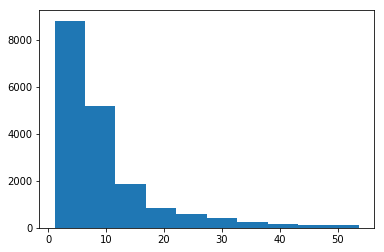

In [99]:
hist(data_table['max_SNR'])

In [106]:
len(data_table[data_table['max_SNR']>20])

1949

In [100]:
train_highSN = table_train[table_train['max_SNR']>20]
test_highSN = table_test[table_test['max_SNR']>20]

In [101]:
roc_auc_score(test_highSN['label'],test_highSN['p'])

0.764004971925764

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


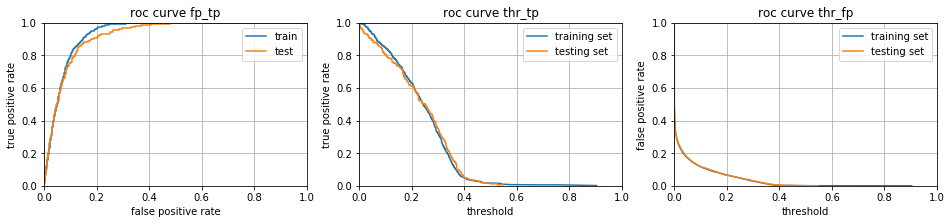

In [102]:
plot_roc_curve(table_train,table_test)

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


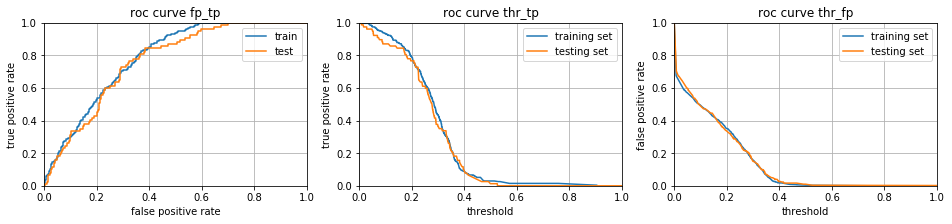

In [103]:
plot_roc_curve(train_highSN,test_highSN)

Text(0,0.5,'Number of Objects')

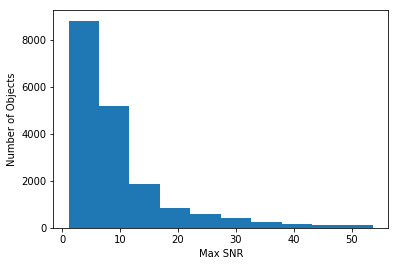

In [107]:
hist(data_table['max_SNR'])
xlabel('Max SNR')
ylabel('Number of Objects')

In [48]:
FP_SNR = FP_table['max_SNR']
FN_SNR = FN_table['max_SNR']
TP_SNR = TP_table['max_SNR']
TN_SNR = TN_table['max_SNR']

In [49]:
# Get S/N for FN from specific types
# WRONG
FN_nine_SNR = FN_nine['max_SNR'] # -9
FN_Ibc_SNR = FN_Ibc['max_SNR'] #3
FN_IIn_SNR = FN_IIn['max_SNR'] #21
FN_IIP_SNR = FN_IIP['max_SNR'] #22
FN_IIL_SNR = FN_IIL['max_SNR'] #23
FN_Ib_SNR = FN_Ib['max_SNR'] #32
FN_Ic_SNR = FN_Ic['max_SNR'] #33

In [50]:
# Get S/N for FN from specific types
FP_nine_SNR = FP_nine['max_SNR'] # -9
FP_Ibc_SNR = FP_Ibc['max_SNR'] #3
FP_IIn_SNR = FP_IIn['max_SNR'] #21
FP_IIP_SNR = FP_IIP['max_SNR'] #22
FP_IIL_SNR = FP_IIL['max_SNR'] #23
FP_Ib_SNR = FP_Ib['max_SNR'] #32
FP_Ic_SNR = FP_Ic['max_SNR'] #33

In [51]:
mis_SNR = np.concatenate((FP_SNR,FN_SNR))
corr_SNR = np.concatenate((TP_SNR,TN_SNR))

mis_nine_SNR = np.concatenate((FP_nine_SNR,FN_nine_SNR))
mis_Ibc_SNR = np.concatenate((FP_Ibc_SNR,FN_Ibc_SNR))
mis_IIn_SNR = np.concatenate((FP_IIn_SNR,FN_IIn_SNR))
mis_IIP_SNR = np.concatenate((FP_IIP_SNR,FN_IIP_SNR))
mis_IIL_SNR = np.concatenate((FP_IIL_SNR,FN_IIL_SNR))
mis_Ib_SNR = np.concatenate((FP_Ib_SNR,FN_Ib_SNR))
mis_Ic_SNR = np.concatenate((FP_Ic_SNR,FN_Ic_SNR))

In [52]:
SNIa_SNR = table_test[table_test['label']==1]['max_SNR']
other_SNR = table_test[table_test['label']==0]['max_SNR']

In [53]:
whole_SNIa_SNR = data_table[data_table['label']==1]['max_SNR']
whole_other_SNR = data_table[data_table['label']==0]['max_SNR']

Text(0.5,1,'S/N for TP+TN vs FP+FN')

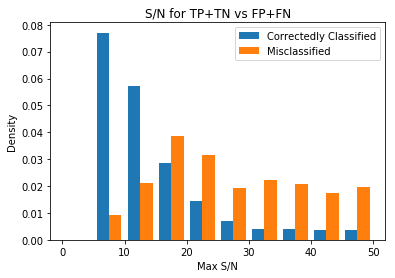

In [54]:
hist([corr_SNR,mis_SNR], 10, (0,50), density = True, histtype='bar', label = ["Correctedly Classified","Misclassified"])
legend(prop={'size': 10})
xlabel('Max S/N')
ylabel('Density')
title("S/N for TP+TN vs FP+FN")

Text(0.5,1,'S/N for FP,FN')

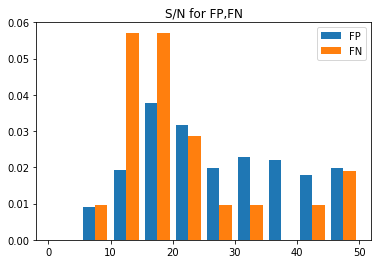

In [58]:
hist([FP_SNR,FN_SNR], 10, (0,50), density = True, histtype='bar', label = ["FP","FN"])
legend(prop={'size': 10})
title("S/N for FP,FN")

Text(0.5,1,'S/N for train/test')

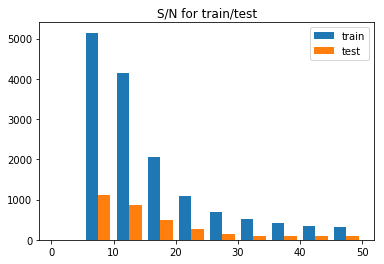

In [56]:
hist([table_train['max_SNR'],table_test['max_SNR']], 10, (0,50),  histtype='bar', label = ["train","test"])
legend(prop={'size': 10})
title("S/N for train/test")

Text(0.5,1,'S/N for TP+TN vs FP+FN')

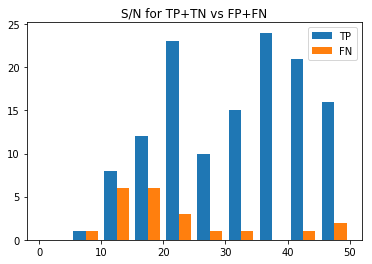

In [59]:
hist([TP_SNR,FN_SNR], 10, (0,50), histtype='bar', label = ["TP","FN"])
legend(prop={'size': 10})
title("S/N for TP,FN")

Text(0.5,1,'S/N for TP+TN vs FP+FN')

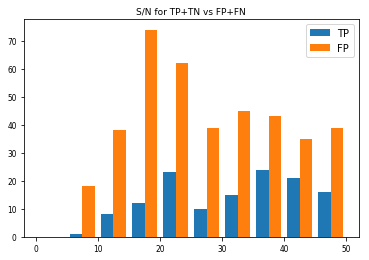

In [157]:
hist([TP_SNR,FP_SNR], 10, (0,50), histtype='bar', label = ["TP","FP"])
legend(prop={'size': 10})
title("S/N for TP,FP")

Text(0.5,1,'S/N for SNIa vs other in the whole data set')

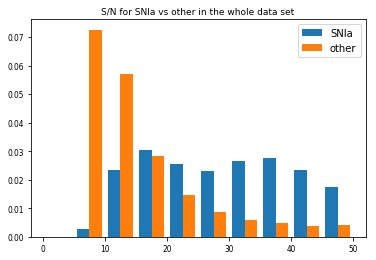

In [158]:
hist([whole_SNIa_SNR,whole_other_SNR], 10, (0,50), density = True, histtype='bar', label = ["SNIa","other"])
legend(prop={'size': 10})
title("S/N for SNIa vs other in the whole data set")

Text(0.5,1,'S/N for SNIa vs other in testing set')

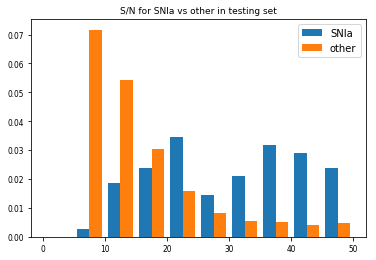

In [159]:
hist([SNIa_SNR,other_SNR], 10, (0,50), density = True, histtype='bar', label = ["SNIa","other"])
legend(prop={'size': 10})
title("S/N for SNIa vs other in testing set")

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/numpy/lib/function_base.py:838: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges


Text(0.5,1,'S/N of FP in specific types')

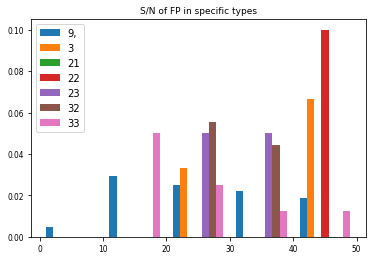

In [160]:
hist([mis_nine_SNR, mis_Ibc_SNR,mis_IIn_SNR,mis_IIP_SNR,mis_IIL_SNR,mis_Ib_SNR,mis_Ic_SNR], 5, (0,50), True, histtype='bar', 
     label = ["9,","3","21","22","23","32","33"])
legend(prop={'size': 10})
title("S/N of FP in specific types")

In [161]:
fp_highSN = FP_table[np.asarray(FP_SNR)>40]

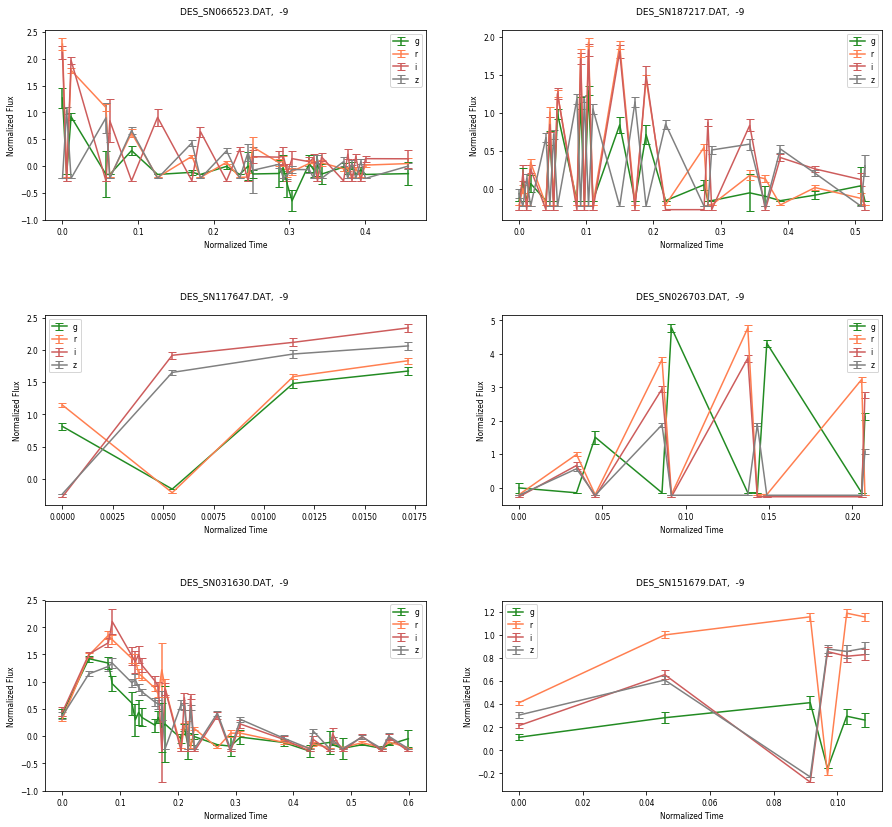

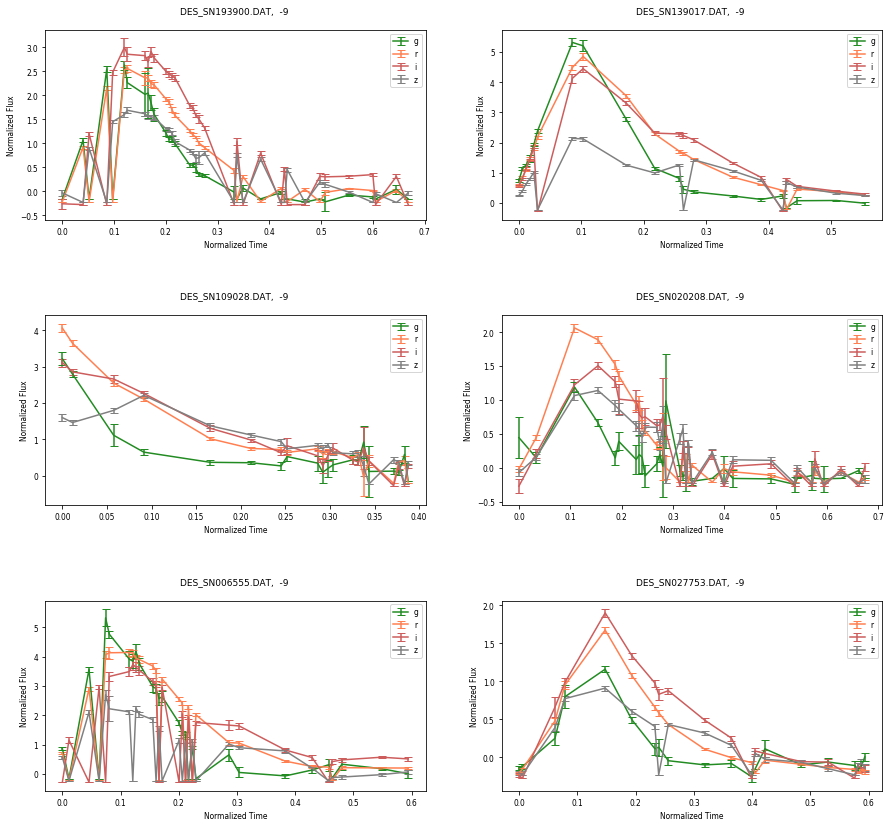

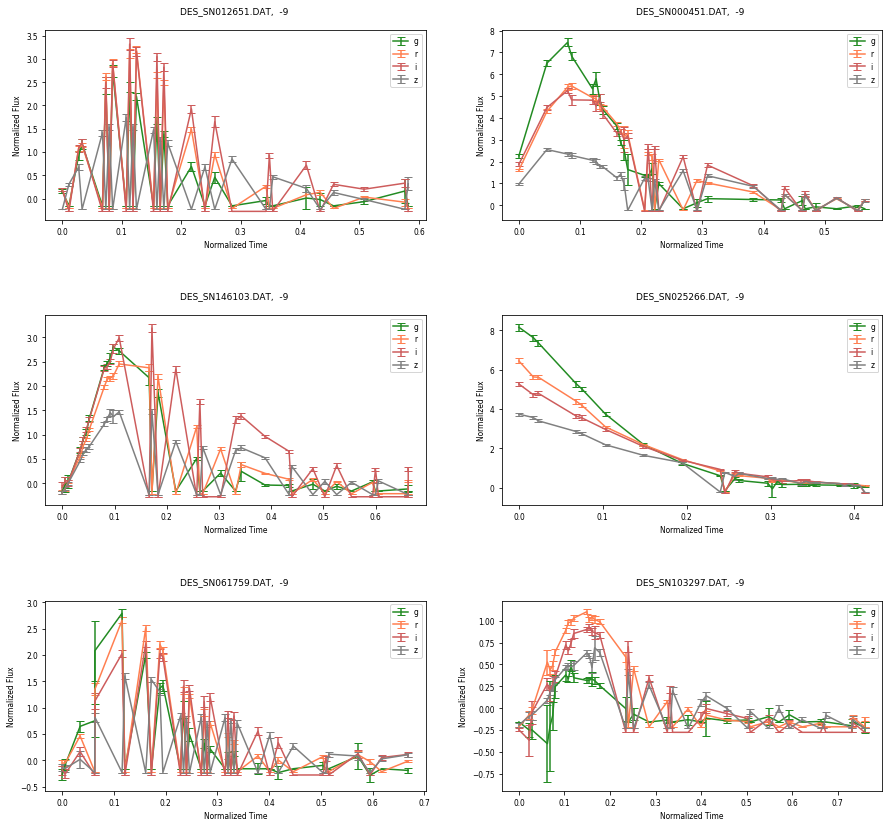

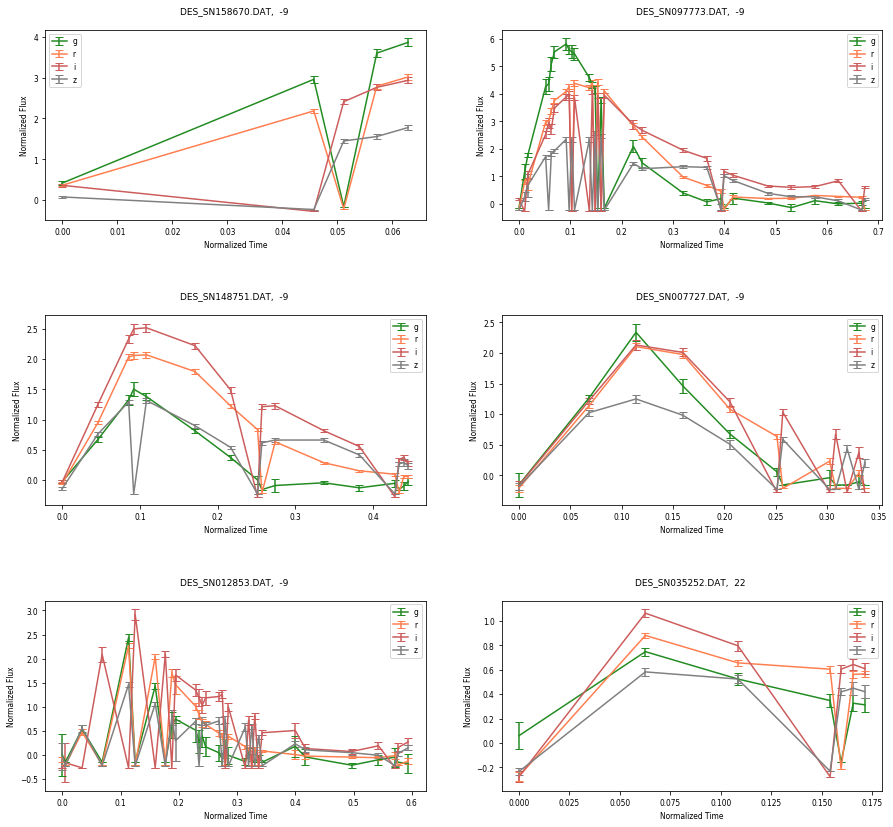

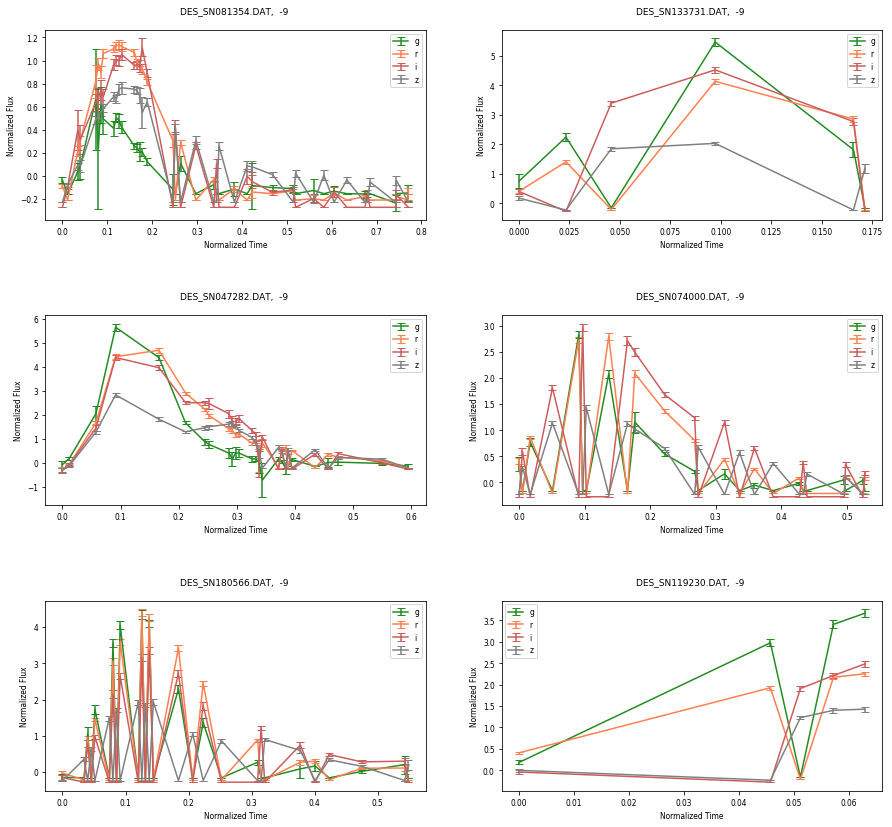

In [162]:
# Make plots for missclassified types with high SN

make_plots(fp_highSN)

In [163]:
# obs_length analysis

train_obs_l = (table_train['obs_length']).tolist()
test_obs_l = (table_test['obs_length']).tolist()
FP_obs_l = (FP_table['obs_length']).tolist()
FN_obs_l = (FN_table['obs_length']).tolist()
TP_obs_l = (TP_table['obs_length']).tolist()
TN_obs_l = (TN_table['obs_length']).tolist()
h_SNIa_obs_l = data_table[data_table['label']==1]['obs_length']
h_other_SNR_obs_l = data_table[data_table['label']==0]['obs_length']

In [164]:
miss_obs_l = FP_obs_l + FN_obs_l
corr_obs_l = TP_obs_l + TN_obs_l

Text(0.5,1,'obs_length for TP+TN vs FP+FN')

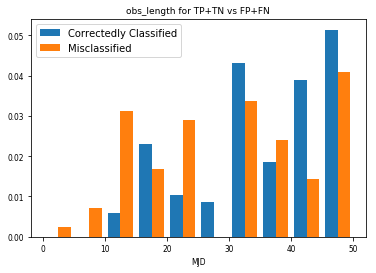

In [165]:
hist([corr_obs_l,miss_obs_l], 10, (0,50), density = True, histtype='bar', label = ["Correctedly Classified","Misclassified"])
legend(prop={'size': 10})
xlabel('MJD')
title("obs_length for TP+TN vs FP+FN")

Text(0.5,1,'obs_length for TP+TN vs FP+FN without normalizing histogram')

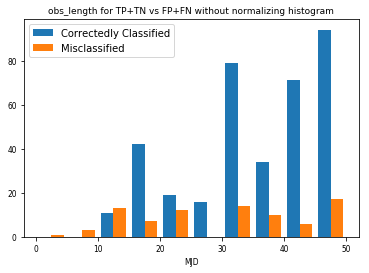

In [166]:
hist([corr_obs_l,miss_obs_l], 10, (0,50),  histtype='bar', label = ["Correctedly Classified","Misclassified"])
legend(prop={'size': 10})
xlabel('MJD')
title("obs_length for TP+TN vs FP+FN without normalizing histogram")

Text(0.5,1,'obs_l for SNIa vs other in whole data set')

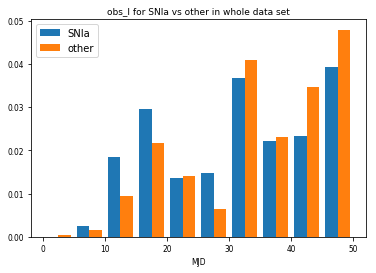

In [167]:
hist([h_SNIa_obs_l,h_other_SNR_obs_l], 10, (0,50), density = True, histtype='bar', label = ["SNIa","other"])
legend(prop={'size': 10})
xlabel('MJD')
title("obs_l for SNIa vs other in whole data set")

In [168]:
np.corrcoef(data_table['obs_length'],data_table['label'])

array([[ 1.  , -0.06],
       [-0.06,  1.  ]])

In [169]:
def bin_study(dataset,arg,cate):
    X = dataset[arg]
    Y = dataset['label']
    predicted_Y = dataset['p'] > threshold

    # Binning
    bins = np.arange(0, 55, 5)
    # Separate data and labels into bins
    B = len(bins) - 1
    inds = np.digitize(X, bins)
    X_binned = [X[inds == i+1] for i in range(B)]
    Y_binned = [Y[inds == i+1] for i in range(B)]
    predicted_Y_binned = [predicted_Y[inds == i+1] for i in range(B)]
    
    dataset_p_binned = [dataset['p'][inds == i+1] for i in range(B)]
    dataset_label_binned = [dataset['label'][inds == i+1] for i in range(B)]
        

    # Calculate false positive rate
    for i in range(B):
        N = len(X_binned[i])
        fp = np.sum(np.logical_and(Y_binned[i] == 0, predicted_Y_binned[i] == 1))
        tp = np.sum(np.logical_and(Y_binned[i] == 1, predicted_Y_binned[i] == 1))
        tn = np.sum(np.logical_and(Y_binned[i] == 0, predicted_Y_binned[i] == 0))
        fn = np.sum(np.logical_and(Y_binned[i] == 1, predicted_Y_binned[i] == 0))
        a = 0
        if len(np.unique(dataset_label_binned[i]))>1:
            a = roc_auc_score(dataset_label_binned[i],dataset_p_binned[i])
        if cate == 'fpr':
            print("False positive rate of bin (%.1f, %.1f) is %.2f%%" % (bins[i], bins[i+1], fp/(fp+tn)*100))
        elif cate == 'tpr':
            print("True positive rate of bin (%.1f, %.1f) is %.2f%%" % (bins[i], bins[i+1], tp/(tp+fn)*100))
        elif cate == 'roc':
            print("Roc score of bin (%.1f, %.1f) is %.5f" % (bins[i], bins[i+1], a))

In [170]:
bin_study(table_test,'obs_length','roc')

Roc score of bin (0.0, 5.0) is 0.00000
Roc score of bin (5.0, 10.0) is 0.00000
Roc score of bin (10.0, 15.0) is 0.98413
Roc score of bin (15.0, 20.0) is 0.91818
Roc score of bin (20.0, 25.0) is 0.71296
Roc score of bin (25.0, 30.0) is 1.00000
Roc score of bin (30.0, 35.0) is 0.91762
Roc score of bin (35.0, 40.0) is 0.00000
Roc score of bin (40.0, 45.0) is 0.98198
Roc score of bin (45.0, 50.0) is 0.80566


In [171]:
bin_study(table_test,'max_SNR','roc')

Roc score of bin (0.0, 5.0) is 0.00000
Roc score of bin (5.0, 10.0) is 0.90294
Roc score of bin (10.0, 15.0) is 0.89462
Roc score of bin (15.0, 20.0) is 0.83626
Roc score of bin (20.0, 25.0) is 0.89256
Roc score of bin (25.0, 30.0) is 0.85175
Roc score of bin (30.0, 35.0) is 0.80043
Roc score of bin (35.0, 40.0) is 0.78739
Roc score of bin (40.0, 45.0) is 0.76207
Roc score of bin (45.0, 50.0) is 0.78644


Text(0.5,0,'obs_length')

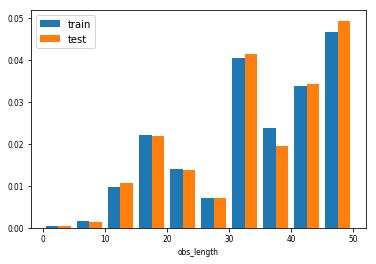

In [172]:
hist([train_obs_l,test_obs_l], 10, (0,50), density = True, histtype='bar', label = ["train","test"])
legend(prop={'size': 10})
xlabel('obs_length')

In [173]:
bin_study(table_test,'max_SNR','tpr')

True positive rate of bin (0.0, 5.0) is nan%
True positive rate of bin (5.0, 10.0) is 50.00%
True positive rate of bin (10.0, 15.0) is 57.14%
True positive rate of bin (15.0, 20.0) is 66.67%
True positive rate of bin (20.0, 25.0) is 88.46%
True positive rate of bin (25.0, 30.0) is 90.91%
True positive rate of bin (30.0, 35.0) is 93.75%
True positive rate of bin (35.0, 40.0) is 100.00%
True positive rate of bin (40.0, 45.0) is 95.45%
True positive rate of bin (45.0, 50.0) is 88.89%


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in long_scalars


Text(0.5,0,'obs_length')

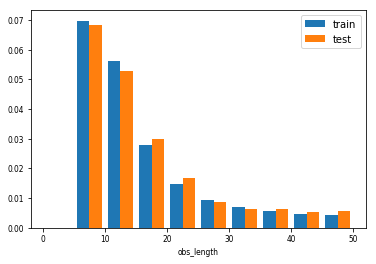

In [174]:
hist([table_train['max_SNR'],table_test['max_SNR']], 10, (0,50), density = True, histtype='bar', label = ["train","test"])
legend(prop={'size': 10})
xlabel('obs_length')

In [175]:
#roc auc score in bins
def roc_hist(dataset,cate):
    (one_res,bins) =  np.histogram(dataset[cate],10,(0,50))
    (two_res,binns) =  np.histogram(two[cate],10,(0,50))
    t_t = one_res/(two_res+one_res)
    roc_auc_score(test_highSN['label'],test_highSN['p'])
    return (bins, t_t)

In [176]:
one = FP_table
two = TN_table

In [177]:
def ratio_hist(one,two,cate):
    (one_res,bins) =  np.histogram(one[cate],10,(0,50))
    (two_res,binns) =  np.histogram(two[cate],10,(0,50))
    t_t = one_res/(two_res+one_res)
    return (bins, t_t)
    

In [178]:
bins,t_t = ratio_hist(one,two,'max_SNR')

In [179]:
binns,t_ttt = ratio_hist(TP_table,FN_table,'max_SNR')

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in true_divide
  after removing the cwd from sys.path.


Text(0,0.5,'true positive rate')

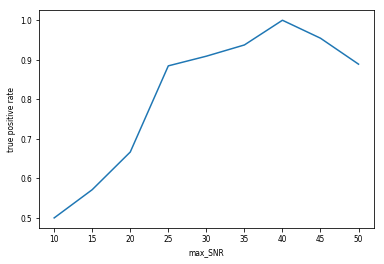

In [180]:
plt.plot(binns[1:],t_ttt)
xlabel('max_SNR')
ylabel('true positive rate')

Text(0,0.5,'false positive rate')

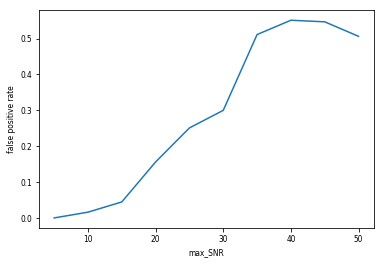

In [181]:
plt.plot(bins[1:],t_t)
xlabel('max_SNR')
ylabel('false positive rate')

In [182]:
#change threshold to fix false positive rate for each bins find the correspondng tpr

In [183]:
binnns,t_tt = ratio_hist(one,two,'obs_length')

Text(0,0.5,'false positive rate')

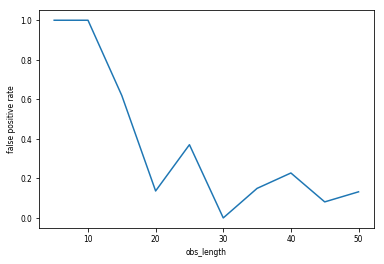

In [184]:
plt.plot(binnns[1:],t_tt)
xlabel('obs_length')
ylabel('false positive rate')